In [ ]:
############################################################################################
# IMPORTS
############################################################################################
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay


import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
#import tensorflow.keras as keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers


from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical



from IPython import display
from PIL import Image


import pathlib
import shutil
import tempfile
import concurrent

import pickle
import visualkeras

import json
import glob





print(tf.__version__)
print(tf.config.list_physical_devices())
############################################################################################

2025-01-05 19:01:58.644147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736100118.678077  264284 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736100118.687651  264284 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 19:01:58.719787: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
############################################################################################
# 1. CONSTANTS - PATHS
############################################################################################

#DATA_FS251 = './data/iFood_2019'
DATA_FS251 = './data/food-101'
CLASSES_FILE_NAME = '/formated_annot/classes_formated.csv'

TRAIN_INFO = '/annot/train_info.csv'
VAL_INFO = '/annot/val_info.csv'
TEST_INFO = '/annot/test_info.csv'

TRAIN_PICS_PATH = './data/iFood_2019/train_set/'
TEST_PICS_PATH = './data/iFood_2019/test_set/'
VAL_PICS_PATH = './data/iFood_2019/val_set/'

MODELS = './models/'

SEED = 111

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
gpu_dev = tf.config.experimental.list_physical_devices('GPU')
for itm in gpu_dev:
    tf.config.experimental.set_memory_growth(itm, True)


############################################################################################
# IMPORTING DATA
############################################################################################
df_classes = pd.read_csv(DATA_FS251 + CLASSES_FILE_NAME)
df_train = pd.read_csv(DATA_FS251 + TRAIN_INFO, names=['file_name', 'class_num'])
df_validate = pd.read_csv(DATA_FS251 + VAL_INFO, names=['file_name', 'class_num'])
df_test = pd.read_csv(DATA_FS251 + TEST_INFO, names=['file_name'])

df_train.head(3)

In [3]:
############################################################################################
# 2. CONSTANTS - MODEL
############################################################################################
training_history = dict()

#N_TRAIN = len(df_train.iloc[:, 0])
EPOCHS = 3
BATCH_SIZE = 64              # 8 fit into GPU RAM, 64 fit into system RAM
RESIZE_TO = (512, 512)
#STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

############################################################################################
# FUNCTIONS, DEFFINITIONS
############################################################################################

class CRelu(tf.keras.Layer):
    def __init__(self, axis=-1, **kwargs):
        self.axis = axis 
        super(CRelu, self).__init__(**kwargs)

    def build(self, input_shape):
        super(CRelu, self).build(input_shape)

    def call(self, x):
        x = tf.nn.crelu(x, axis=self.axis)
        return x

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] = output_shape[-1] * 2
        output_shape = tuple(output_shape)
        return output_shape

    def get_config(self, input_shape):
        config = {'axis': self.axis, }
        base_config = super(CReLU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
############################################################################################
# import image files
############################################################################################

train_pics, val_pics = tf.keras.preprocessing.image_dataset_from_directory(
    './data/food-101/images/',
    labels='inferred',
#    label_mode='int',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
#    image_size=RESIZE_TO,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='both',
#    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format='channels_last',
    verbose=True
)
#test_pics = tf.keras.preprocessing.image_dataset_from_directory(
#    VAL_PICS_PATH,
#    labels='inferred',
#    label_mode='int',
#    label_mode='categorical',
#    class_names=None,
#    color_mode='rgb',
#    batch_size=BATCH_SIZE,
#    image_size=RESIZE_TO,
#    shuffle=True,
#    seed=SEED,
#    validation_split=None,
#    subset=None,
#    interpolation='bilinear',
#    follow_links=False,
#    crop_to_aspect_ratio=False,
#    pad_to_aspect_ratio=False,
#    data_format='channels_last',
#    verbose=True
#)
#true_test_pics = tf.keras.preprocessing.image_dataset_from_directory(
#    TEST_PICS_PATH,
#    labels=None,
#    label_mode=None,
#    class_names=None,
#    color_mode='rgb',
#    batch_size=BATCH_SIZE,
#    image_size=RESIZE_TO,
#    shuffle=True,
#    seed=SEED,
#    validation_split=None,
#    subset=None,
#    interpolation='bilinear',
#    follow_links=False,
#    crop_to_aspect_ratio=False,
#    pad_to_aspect_ratio=False,
#    data_format='channels_last',
#    verbose=True
#)

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Using 20200 files for validation.


I0000 00:00:1736100131.666443  264284 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5457 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1


In [5]:
train_pics.class_names
#val_pics.as_numpy_iterator().next()[0]
#val_pics.take(1)

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
############################################################################################
# DEFINING THE MODEL
############################################################################################
tf.keras.backend.clear_session()

core_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(240, 240, 3))
core_model.trainable = True
#for layer in core_model.layers[:-5]:
#    layer.trainable = False

inputed = tf.keras.Input(shape=(256,256,3))
x = tf.keras.layers.Resizing(height = 240,width = 240,interpolation='bilinear',crop_to_aspect_ratio=False,pad_to_aspect_ratio=False,fill_mode='constant',fill_value=0.0)(inputed)
x = tf.keras.layers.RandomRotation(factor=0.4, seed=SEED)(x)
x = core_model(x)

#x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)

y = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)

x = tf.keras.layers.BatchNormalization()(x)
y = tf.keras.layers.BatchNormalization()(y)


x = tf.keras.layers.Dense(1024, activation=None, activity_regularizer=None)(x)
y = tf.keras.layers.Dense(1024, activation=None, activity_regularizer=None)(y)

x = tf.keras.layers.BatchNormalization()(x)
y = tf.keras.layers.BatchNormalization()(y)

x = tf.keras.layers.LeakyReLU(0.1)(x)
y = tf.keras.layers.LeakyReLU(0.1)(y)

#x = tf.keras.layers.Dense(256, activation=None, activity_regularizer=None)(x)
#y = tf.keras.layers.Dense(256, activation=None, activity_regularizer=None)(y)

#x = tf.keras.layers.BatchNormalization()(x)
#y = tf.keras.layers.BatchNormalization()(y)

#x = tf.keras.layers.LeakyReLU(0.1)(x)
#y = tf.keras.layers.LeakyReLU(0.1)(y)

x = tf.keras.layers.Concatenate()([x, y])
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation=None, activity_regularizer=None)(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputed = tf.keras.layers.Dense(units=101,activation='softmax',activity_regularizer=tf.keras.regularizers.L2(), name='Output_layer')(x)


model_supclass = tf.keras.Model(inputed,outputed)

model_supclass.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 240, 240,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 8, 8,      │  4,049,571 │ resizing[0][0]    │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1280)      │      5,120 │ global_max_pooli… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1280)      │      5,120 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  1,311,744 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │  1,311,744 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 1024)      │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 1024)      │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2048)      │          0 │ leaky_re_lu[0][0… │
│ (Concatenate)       │                   │            │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_layer        │ (None, 101)       │     25,957 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,250,184 (27.66 MB)

 Trainable params: 7,194,849 (27.45 MB)

 Non-trainable params: 55,335 (216.16 KB)

In [7]:
############################################################################################
# SCHEDULER PARAMS
############################################################################################
#lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#    0.00005, #0.000005
#    decay_steps=STEPS_PER_EPOCH*100, #100
#    decay_rate=1,
#    staircase=False)

In [8]:
############################################################################################
# COMPILING
############################################################################################

model_supclass.compile(
#        optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),                     
#        optimizer = tf.keras.optimizers.Adam(),                                     #
#        optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.5),                 #3            
#        optimizer = tf.keras.optimizers.Adagrad(),                                             
#        optimizer = tf.keras.optimizers.Adam(0.001),
#        optimizer = tf.keras.optimizers.Nadam(),
#        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.05),                 #1
        optimizer = tf.keras.optimizers.Nadam(learning_rate=0.005),                  #2
#        loss = tf.keras.losses.CTC(),
#        loss = tf.keras.losses.KLDivergence(),
#        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3),
        loss = tf.keras.losses.CategoricalCrossentropy(),
#        loss = tf.keras.losses.BinaryCrossentropy(),
#        loss = tf.keras.losses.CategoricalCrossentropy(),
#        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
#        metrics = [tf.keras.metrics.CategoricalCrossentropy(from_logits=False, label_smoothing=0.2, axis=-1),
#                   tf.keras.metrics.F1Score(average=None, threshold=0.5, dtype=None),
#                   tf.keras.metrics.CategoricalAccuracy()]
        metrics = [tf.keras.metrics.Accuracy()]
#        metrics = [tf.keras.metrics.F1Score(average='micro', threshold=0.5),tf.keras.metrics.CategoricalAccuracy()]
        )

In [9]:
############################################################################################
# FITTING
############################################################################################


with tf.device('/GPU:0'):
    model_history = model_supclass.fit(
        train_pics,
        epochs = EPOCHS, 
        batch_size = BATCH_SIZE,
        callbacks = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.2,
                            patience=3,
                            verbose=1,
                            mode='auto',
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0),
        validation_data = val_pics
#        validation_split = 0.1
    )

Epoch 1/3


I0000 00:00:1736100211.570610  264549 service.cc:148] XLA service 0x71fbf00026c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736100211.570646  264549 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 with Max-Q Design, Compute Capability 6.1
2025-01-05 19:03:33.997282: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736100220.637165  264549 cuda_dnn.cc:529] Loaded cuDNN version 90600
E0000 00:00:1736100246.120444  264549 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736100246.300547  264549 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736100

1262/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.0060 - loss: 6.5073

E0000 00:00:1736100956.540985  264552 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736100956.706718  264552 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736100957.649732  264552 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736100957.820750  264552 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736100958.441165  264552 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 913s 604ms/step - accuracy: 0.0060 - loss: 6.5050 - val_accuracy: 0.0000e+00 - val_loss: 4.0313
Epoch 2/3
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 691s 547ms/step - accuracy: 0.0000e+00 - loss: 3.6285 - val_accuracy: 0.0000e+00 - val_loss: 3.1895
Epoch 3/3
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 693s 549ms/step - accuracy: 0.0000e+00 - loss: 2.8679 - val_accuracy: 1.3381e-04 - val_loss: 3.0353
Restoring model weights from the end of the best epoch: 2.


In [10]:
############################################################################################
# SAVING MODEL
############################################################################################
MODEL_NAME = 'XYSplit-food-101-EfNetB0-A0.00-earlystopMD0.2P3-E3-B64_softCat_v0.6'
os.makedirs( os.path.dirname(MODELS + 'test/' + MODEL_NAME + '/'), exist_ok=True)
model_supclass.save(MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + ".keras")
#model_supclass_loaded = load_model(MODELS + MODEL_NAME + '/'+ MODEL_NAME + ".keras")
#model_supclass_loaded.summary()

# with pickle
import pickle
with open(MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + ".pckl", 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)

# history in csv format
hits_df = []
hits_df = pd.DataFrame(model_history.history)
hits_df.to_csv(MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + '.hist_csv')


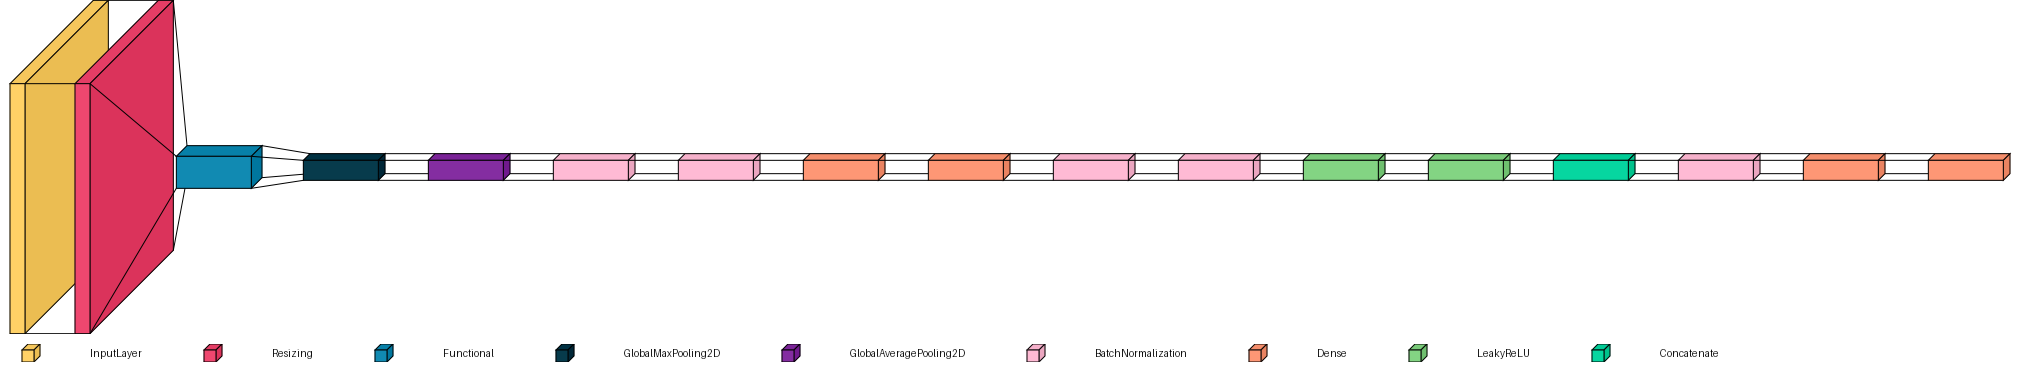

In [11]:
############################################################################################
# EVALUATION - MODEL STRUCTURE IMAGES
############################################################################################
tf.keras.utils.plot_model(
    model_supclass,
    to_file=MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + '_model_diagram.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True
)

import visualkeras
visualkeras.layered_view(model_supclass,
                        to_file=MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + '_layer_plot.png',
                        legend=True,
                        max_xy=250,
                        min_z = 1, 
                        max_z= 75,
                        scale_z = 5,
#                        color_map = color_map,
#                        show_nested = True,
                        spacing=50
#                        show_dimension=True
                        )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


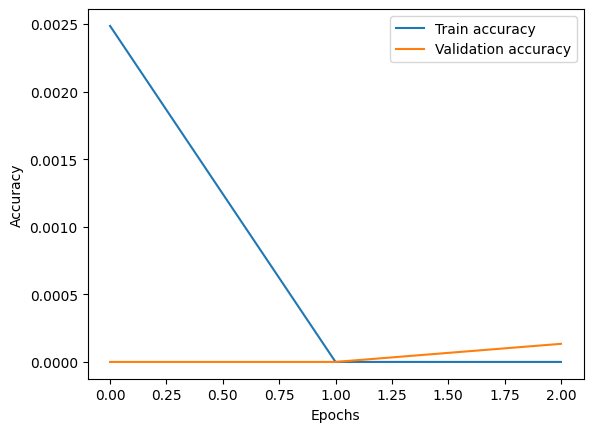

In [12]:
############################################################################################
# EVALUATION - ACCURACY
############################################################################################

plt.legend(bbox_to_anchor = [1, 1.02])
plt.plot(model_history.history['accuracy'],label='Train accuracy')
plt.plot(model_history.history['val_accuracy'],label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + '_ACCURACY.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


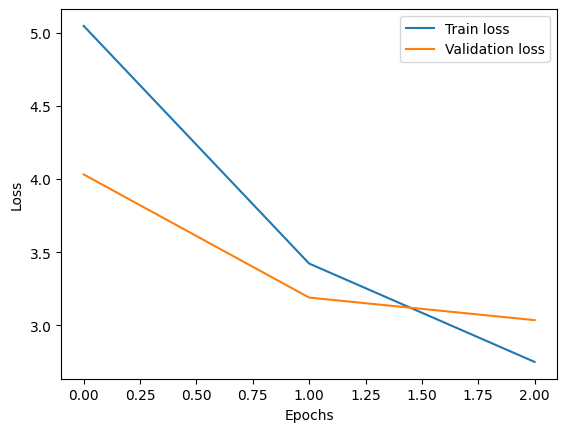

316/316 ━━━━━━━━━━━━━━━━━━━━ 44s 139ms/step - accuracy: 0.0000e+00 - loss: 3.2025
[3.189465045928955, 0.0] ['loss', 'compile_metrics']


In [13]:
############################################################################################
# EVALUATION - LOSS
############################################################################################

plt.legend(bbox_to_anchor = [1, 1.02])
plt.plot(model_history.history['loss'],label='Train loss')
plt.plot(model_history.history['val_loss'],label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + '_LOSS.png')
plt.legend()
plt.show()

# Print out the score
score = model_supclass.evaluate(val_pics , batch_size=1, verbose=1)
print(score, model_supclass.metrics_names)

In [14]:
############################################################################################
# PREDICTION
############################################################################################

y_test_pred = np.array([])
y_test =  np.array([])
for x, y in val_pics:
        y_test_pred = np.concatenate([y_test_pred, np.argmax(model_supclass.predict(x, verbose=0), axis = -1)])
        y_test = np.concatenate([y_test, np.argmax(y.numpy(), axis=-1)])
        print(model_supclass.predict(x, verbose=0))
        print(x.shape)
        print(y.shape)

[[8.7864837e-03 8.7904166e-03 2.3524590e-04 ... 2.2345706e-05
  3.6342337e-04 3.5876639e-03]
 [1.2386627e-03 3.9977658e-05 3.9547947e-05 ... 3.0555387e-07
  1.0225514e-05 3.1632775e-05]
 [1.3463916e-03 7.3959690e-04 4.9562991e-04 ... 1.7222162e-02
  6.9353140e-05 4.6042045e-05]
 ...
 [1.3323012e-02 9.1641780e-04 4.8372811e-03 ... 8.5557066e-04
  2.8615359e-03 5.0105983e-03]
 [3.3359326e-02 1.3673579e-04 6.0029384e-03 ... 1.9368346e-04
  2.2810945e-04 7.2765903e-04]
 [3.3389594e-02 6.6755002e-04 2.3707398e-03 ... 2.2121868e-03
  2.2536714e-03 2.9850684e-03]]
(64, 256, 256, 3)
(64, 101)
[[2.4508745e-03 7.2757382e-04 3.5986872e-04 ... 3.9467592e-05
  5.4624397e-05 5.0931224e-03]
 [6.1439802e-03 4.5903314e-02 1.9491441e-03 ... 3.9397797e-04
  2.3715505e-03 2.0164407e-03]
 [2.0825579e-03 3.3183391e-03 1.7830345e-04 ... 1.9242124e-04
  2.4516400e-04 1.8872430e-04]
 ...
 [4.7801468e-03 5.4447735e-03 3.0205608e-03 ... 6.6634254e-03
  3.3865580e-03 3.5312034e-02]
 [1.8072838e-03 4.8624137e-03 3

2025-01-05 19:44:15.073694: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


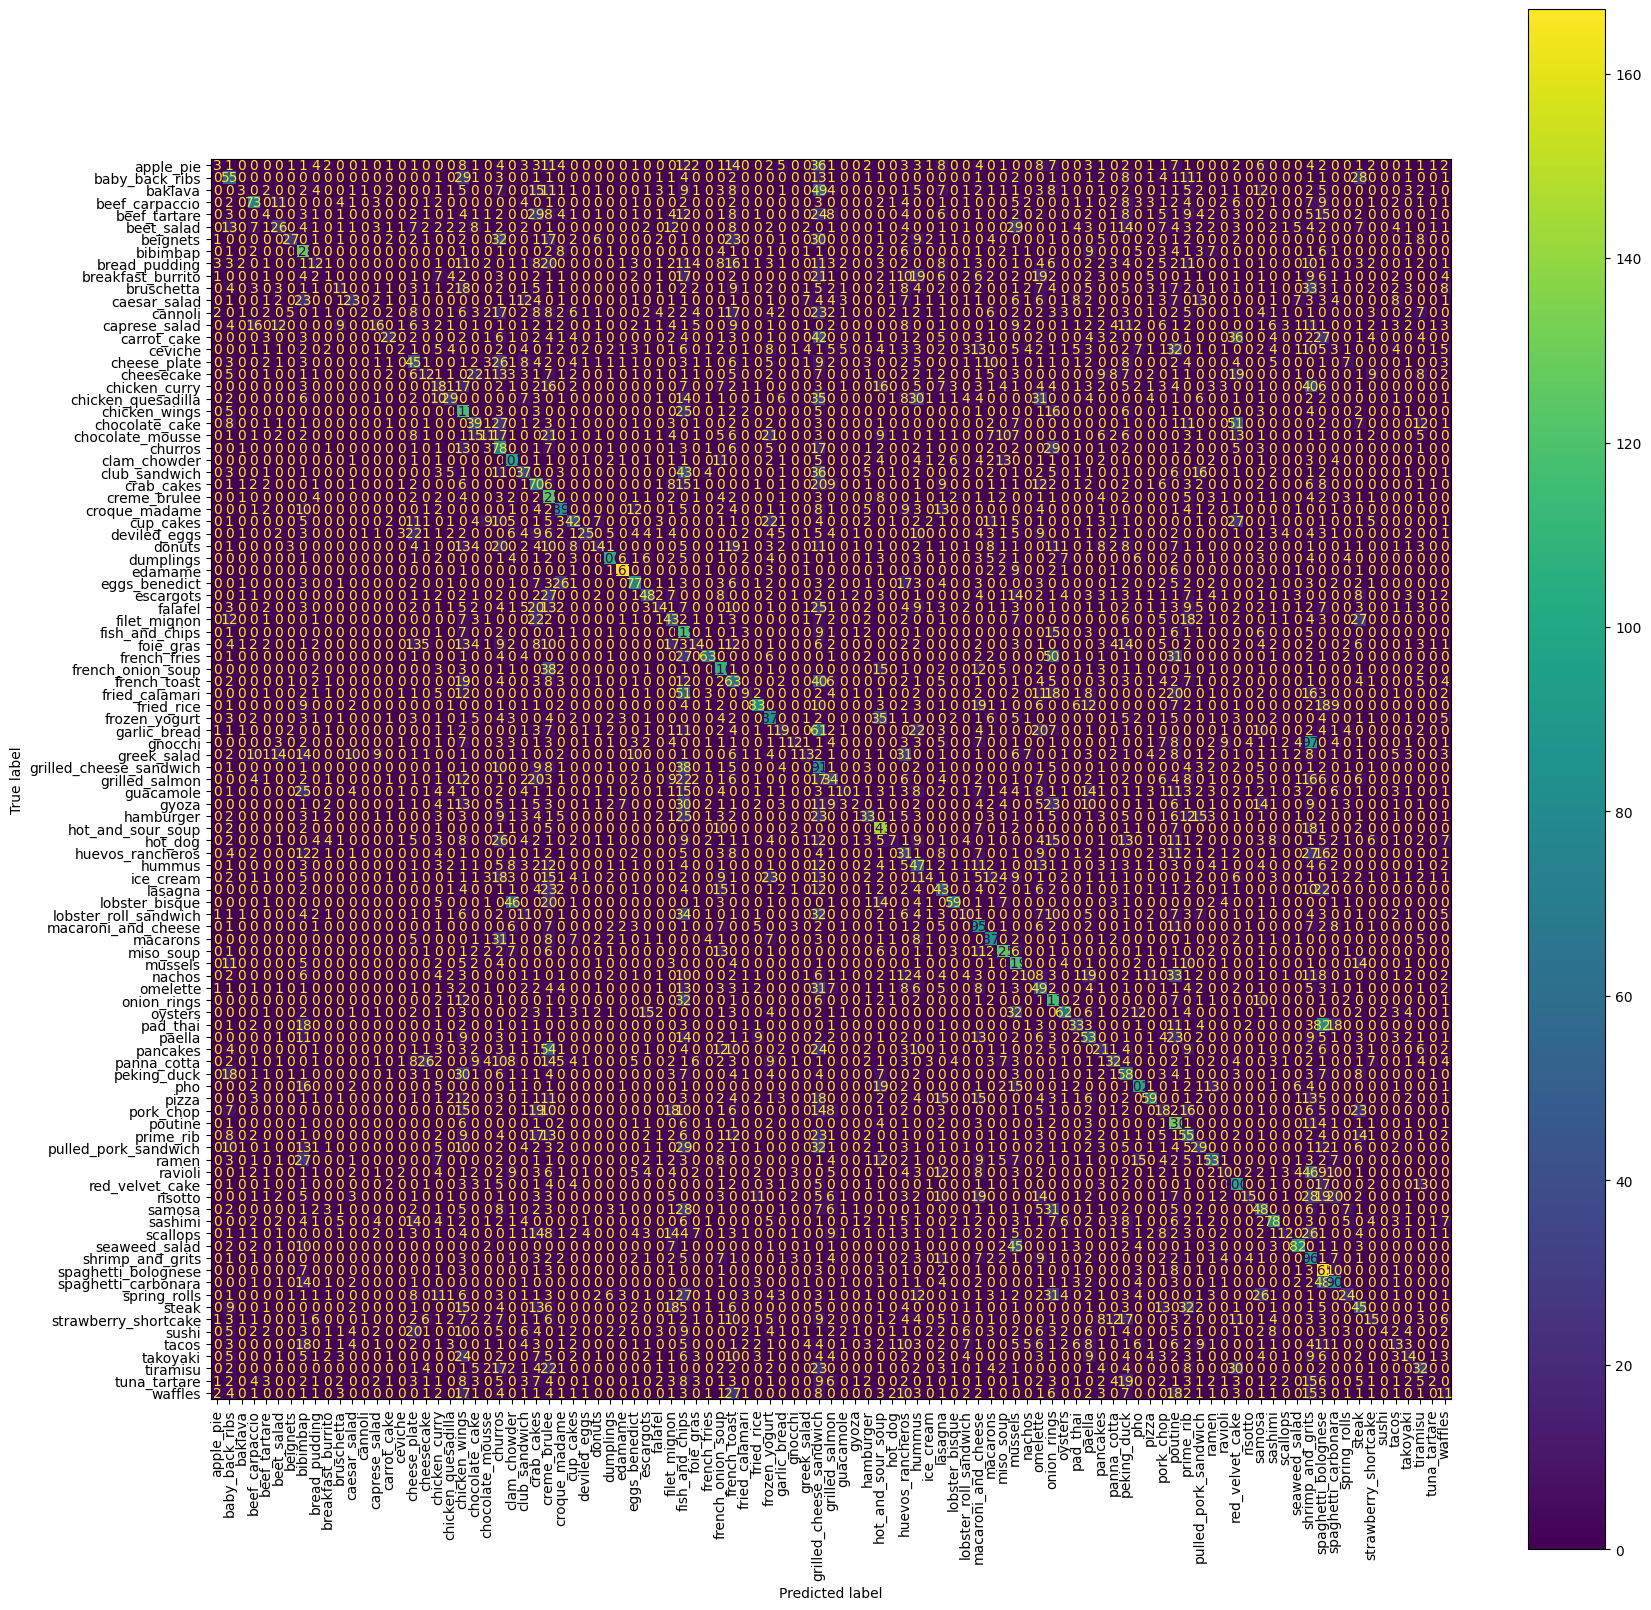

In [ ]:
############################################################################################
# PREDICTION - CONFMATRIX
############################################################################################

from sklearn.metrics import ConfusionMatrixDisplay
plt.rcParams['figure.figsize'] = (20, 20)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true= y_test, y_pred=y_test_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pd.DataFrame(val_pics.class_names))
disp.plot()
plt.xticks(rotation=90)
plt.savefig(MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + '_CONFMAT.png')
plt.show()






ValueError: as_list() is not defined on an unknown TensorShape.

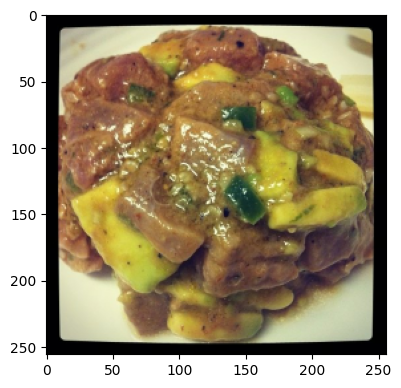

In [16]:
plt.figure(figsize=(15, 15))
for images, labels in val_pics.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str( labels[i].numpy().astype(int) ) + str(np.argmax(model_supclass.predict(images[i], verbose=0), axis = -1))  )
        plt.axis("off")
        

In [ ]:
#plt.imshow(images[0].numpy().astype("uint8"))
#plt.show()
